In [1]:
# region 1. Setup & Core Engine
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from torchvision.models import EfficientNet_V2_S_Weights
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from PIL import Image
import sys
import warnings

warnings.filterwarnings("ignore")

# --- HARDWARE SETUP ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if DEVICE.type == 'cuda':
    # Optimasi RTX 5060 (Ampere/Blackwell)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    AMP_DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
else:
    AMP_DTYPE = torch.float32

print(f"Device    : {torch.cuda.get_device_name(0)}")
print(f"Precision : {AMP_DTYPE}")
print(f"TF32 Mode : {'Enabled' if torch.backends.cuda.matmul.allow_tf32 else 'Disabled'}")

def train_engine(model, criterion, optimizer, scheduler, loaders, sizes, epochs, name="Train"):
    since = time.time()
    best_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'t_loss': [], 't_acc': [], 'v_loss': [], 'v_acc': []}

    print(f"\n>>> START: {name} ({epochs} Epochs)")
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs} | LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            run_loss, run_corrects = 0.0, 0
            
            pbar = tqdm(loaders[phase], desc=f"{phase.upper()}", leave=True, ncols=100)
            
            for inputs, labels in pbar:
                # --- UPDATE: Channels Last Memory Format ---
                # Mengubah layout memori agar optimal untuk Tensor Cores
                inputs = inputs.to(DEVICE, memory_format=torch.channels_last, non_blocking=True)
                labels = labels.to(DEVICE, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == 'train'), \
                     torch.autocast(device_type=DEVICE.type, dtype=AMP_DTYPE, enabled=True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    
                    # --- UPDATE: Gradient Clipping ---
                    # Mencegah NaN/Exploding Gradient
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    
                    optimizer.step()

                run_loss += loss.item() * inputs.size(0)
                run_corrects += torch.sum(preds == labels.data).item()
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

            epoch_loss = run_loss / sizes[phase]
            epoch_acc = run_corrects / sizes[phase]
            
            if phase == 'train':
                history['t_loss'].append(epoch_loss); history['t_acc'].append(epoch_acc)
                print(f"   TRAIN | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
            else:
                history['v_loss'].append(epoch_loss); history['v_acc'].append(epoch_acc)
                print(f"   VAL   | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
                
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f'best_{name.lower()[:4]}.pth')
        
        if scheduler: scheduler.step()

    time_elapsed = time.time() - since
    print(f"\n{name} Done: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s | Best Acc: {best_acc:.4f}")
    model.load_state_dict(best_wts)
    return model, history
# endregion

Device    : NVIDIA GeForce RTX 5060
Precision : torch.bfloat16
TF32 Mode : Enabled


In [2]:
# region 2. Config & Data Loader
DATA_DIR = 'Dataset'
IMG_SIZE = 224
BATCH_SIZE = 32

NUM_WORKERS = 0

EPOCHS_FE = 10
EPOCHS_FT = 20
LR_FE = 1e-3
LR_FT = 1e-4

class RAMDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, img_size=224):
        self.samples = []
        self.targets = []
        temp_ds = datasets.ImageFolder(root_dir)
        self.classes = temp_ds.classes
        
        print(f"(!) Caching {len(temp_ds)} images to RAM...")
        for path, target in tqdm(temp_ds.samples, desc="Caching"):
            with open(path, 'rb') as f:
                img = Image.open(f).convert('RGB')
                img = img.resize((img_size, img_size)) 
                self.samples.append(img)
                self.targets.append(target)
                
    def __getitem__(self, index):
        return self.samples[index], self.targets[index]
    def __len__(self):
        return len(self.samples)

class AugmentedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        img, target = self.subset[index]
        return self.transform(img), target
    def __len__(self):
        return len(self.subset)

def get_data():
    weights = EfficientNet_V2_S_Weights.DEFAULT
    
    # Augmentasi
    train_tf = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        full_data = RAMDataset(DATA_DIR, img_size=IMG_SIZE)
        classes = full_data.classes
        
        train_len = int(0.8 * len(full_data))
        val_len = len(full_data) - train_len
        train_sub, val_sub = random_split(full_data, [train_len, val_len], generator=torch.Generator().manual_seed(42))

        train_ds = AugmentedSubset(train_sub, train_tf)
        val_ds = AugmentedSubset(val_sub, val_tf)

        loaders = {
            'train': DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                                num_workers=NUM_WORKERS, pin_memory=True),
            'val': DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, 
                              num_workers=NUM_WORKERS, pin_memory=True)
        }
        sizes = {'train': len(train_ds), 'val': len(val_ds)}
        
        print(f"Cached: {len(full_data)} images. Workers: {NUM_WORKERS}")
        return loaders, sizes, classes, len(classes)

    except Exception as e:
        print(f"Error: {e}")
        sys.exit(1)

if __name__ == '__main__':
    loaders, sizes, class_names, num_classes = get_data()
# endregion

(!) Caching 38432 images to RAM...


Caching: 100%|██████████| 38432/38432 [00:42<00:00, 913.74it/s] 

Cached: 38432 images. Workers: 0


In [3]:
# region 3. Feature Extraction
if __name__ == '__main__':
    if 'loaders' not in locals():
        loaders, sizes, class_names, num_classes = get_data()

    print("\n--- Init Model (FE) ---")
    weights = EfficientNet_V2_S_Weights.DEFAULT
    model = models.efficientnet_v2_s(weights=weights)

    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(model.classifier[1].in_features, num_classes)
    )
    
    # --- UPDATE: Channels Last ---
    # Memaksa model menggunakan layout memori NHWC di VRAM
    model = model.to(DEVICE, memory_format=torch.channels_last)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.classifier.parameters(), lr=LR_FE)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR_FE, 
                                              steps_per_epoch=len(loaders['train']), 
                                              epochs=EPOCHS_FE)

    model, hist_fe = train_engine(
        model, criterion, optimizer, scheduler, loaders, sizes, EPOCHS_FE, "FeatExtract"
    )
    torch.save(model.state_dict(), 'checkpoint_fe.pth')
# endregion


--- Init Model (FE) ---

>>> START: FeatExtract (10 Epochs)
Epoch 1/10 | LR: 4.00e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [01:35<00:00, 10.04it/s, loss=1.0569]


   TRAIN | Loss: 1.2462 | Acc: 0.6191


VAL: 100%|███████████████████████████████████████████| 241/241 [00:22<00:00, 10.87it/s, loss=1.1990]


   VAL   | Loss: 1.0218 | Acc: 0.8354
Epoch 2/10 | LR: 4.00e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [01:30<00:00, 10.58it/s, loss=0.8511]


   TRAIN | Loss: 0.9295 | Acc: 0.7957


VAL: 100%|███████████████████████████████████████████| 241/241 [00:17<00:00, 14.04it/s, loss=1.1111]


   VAL   | Loss: 0.8290 | Acc: 0.8785
Epoch 3/10 | LR: 4.00e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [01:29<00:00, 10.75it/s, loss=0.6899]


   TRAIN | Loss: 0.8174 | Acc: 0.8386


VAL: 100%|███████████████████████████████████████████| 241/241 [00:16<00:00, 14.46it/s, loss=1.0160]


   VAL   | Loss: 0.7609 | Acc: 0.8807
Epoch 4/10 | LR: 4.00e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [01:29<00:00, 10.69it/s, loss=0.8203]


   TRAIN | Loss: 0.7642 | Acc: 0.8581


VAL: 100%|███████████████████████████████████████████| 241/241 [00:16<00:00, 14.68it/s, loss=1.0254]


   VAL   | Loss: 0.7022 | Acc: 0.8992
Epoch 5/10 | LR: 4.00e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [01:29<00:00, 10.79it/s, loss=0.7017]


   TRAIN | Loss: 0.7334 | Acc: 0.8700


VAL: 100%|███████████████████████████████████████████| 241/241 [00:16<00:00, 14.66it/s, loss=0.9979]


   VAL   | Loss: 0.6708 | Acc: 0.9071
Epoch 6/10 | LR: 4.00e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [01:32<00:00, 10.34it/s, loss=0.6654]


   TRAIN | Loss: 0.7100 | Acc: 0.8804


VAL: 100%|███████████████████████████████████████████| 241/241 [00:17<00:00, 13.76it/s, loss=0.9684]


   VAL   | Loss: 0.6653 | Acc: 0.9059
Epoch 7/10 | LR: 4.00e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [01:28<00:00, 10.91it/s, loss=0.6334]


   TRAIN | Loss: 0.7006 | Acc: 0.8837


VAL: 100%|███████████████████████████████████████████| 241/241 [00:16<00:00, 14.87it/s, loss=0.9517]


   VAL   | Loss: 0.6557 | Acc: 0.9156
Epoch 8/10 | LR: 4.00e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [01:30<00:00, 10.60it/s, loss=0.8395]


   TRAIN | Loss: 0.6906 | Acc: 0.8871


VAL: 100%|███████████████████████████████████████████| 241/241 [00:17<00:00, 13.79it/s, loss=0.9420]


   VAL   | Loss: 0.6404 | Acc: 0.9200
Epoch 9/10 | LR: 4.00e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [01:31<00:00, 10.52it/s, loss=0.6774]


   TRAIN | Loss: 0.6819 | Acc: 0.8927


VAL: 100%|███████████████████████████████████████████| 241/241 [00:27<00:00,  8.75it/s, loss=0.9568]


   VAL   | Loss: 0.6292 | Acc: 0.9199
Epoch 10/10 | LR: 4.00e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [01:30<00:00, 10.57it/s, loss=0.7104]


   TRAIN | Loss: 0.6718 | Acc: 0.8962


VAL: 100%|███████████████████████████████████████████| 241/241 [00:17<00:00, 13.98it/s, loss=0.9303]


   VAL   | Loss: 0.6282 | Acc: 0.9234

FeatExtract Done: 18m 15s | Best Acc: 0.9234


In [4]:
# region 4. Fine Tuning
if __name__ == '__main__':
    print("\n--- Fine Tuning (FT) ---")
    
    for param in model.parameters():
        param.requires_grad = True
        
    # Pastikan model tetap dalam format channels_last saat unfreeze
    model = model.to(DEVICE, memory_format=torch.channels_last)

    optimizer = optim.SGD(model.parameters(), lr=LR_FT, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_FT)

    model, hist_ft = train_engine(
        model, criterion, optimizer, scheduler, loaders, sizes, EPOCHS_FT, "FineTuning"
    )
    
    torch.save(model.state_dict(), 'model_final.pth')
    print("Model Saved: model_final.pth")
# endregion


--- Fine Tuning (FT) ---

>>> START: FineTuning (20 Epochs)
Epoch 1/20 | LR: 1.00e-04


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:55<00:00,  5.48it/s, loss=0.5863]


   TRAIN | Loss: 0.6478 | Acc: 0.9074


VAL: 100%|███████████████████████████████████████████| 241/241 [00:19<00:00, 12.11it/s, loss=0.8907]


   VAL   | Loss: 0.5725 | Acc: 0.9464
Epoch 2/20 | LR: 9.94e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:34<00:00,  6.24it/s, loss=0.5741]


   TRAIN | Loss: 0.6177 | Acc: 0.9229


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.83it/s, loss=0.9546]


   VAL   | Loss: 0.5579 | Acc: 0.9528
Epoch 3/20 | LR: 9.76e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:32<00:00,  6.31it/s, loss=0.5497]


   TRAIN | Loss: 0.5929 | Acc: 0.9353


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.86it/s, loss=0.9075]


   VAL   | Loss: 0.5384 | Acc: 0.9624
Epoch 4/20 | LR: 9.46e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:32<00:00,  6.31it/s, loss=0.6460]


   TRAIN | Loss: 0.5723 | Acc: 0.9484


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.86it/s, loss=0.8419]


   VAL   | Loss: 0.5235 | Acc: 0.9694
Epoch 5/20 | LR: 9.05e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:34<00:00,  6.21it/s, loss=0.5889]


   TRAIN | Loss: 0.5600 | Acc: 0.9514


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.74it/s, loss=0.8354]


   VAL   | Loss: 0.5163 | Acc: 0.9716
Epoch 6/20 | LR: 8.54e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:36<00:00,  6.15it/s, loss=0.4869]


   TRAIN | Loss: 0.5484 | Acc: 0.9573


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.50it/s, loss=0.7798]


   VAL   | Loss: 0.5079 | Acc: 0.9761
Epoch 7/20 | LR: 7.94e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:40<00:00,  5.99it/s, loss=0.6687]


   TRAIN | Loss: 0.5395 | Acc: 0.9621


VAL: 100%|███████████████████████████████████████████| 241/241 [00:19<00:00, 12.13it/s, loss=0.7910]


   VAL   | Loss: 0.5008 | Acc: 0.9779
Epoch 8/20 | LR: 7.27e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:35<00:00,  6.19it/s, loss=0.4877]


   TRAIN | Loss: 0.5329 | Acc: 0.9651


VAL: 100%|███████████████████████████████████████████| 241/241 [00:19<00:00, 12.18it/s, loss=0.6269]


   VAL   | Loss: 0.4910 | Acc: 0.9823
Epoch 9/20 | LR: 6.55e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:39<00:00,  6.04it/s, loss=0.5077]


   TRAIN | Loss: 0.5226 | Acc: 0.9690


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.65it/s, loss=0.7168]


   VAL   | Loss: 0.4865 | Acc: 0.9826
Epoch 10/20 | LR: 5.78e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:36<00:00,  6.14it/s, loss=0.4726]


   TRAIN | Loss: 0.5186 | Acc: 0.9700


VAL: 100%|███████████████████████████████████████████| 241/241 [00:19<00:00, 12.47it/s, loss=0.6698]


   VAL   | Loss: 0.4830 | Acc: 0.9830
Epoch 11/20 | LR: 5.00e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:36<00:00,  6.13it/s, loss=0.5138]


   TRAIN | Loss: 0.5153 | Acc: 0.9716


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.93it/s, loss=0.6739]


   VAL   | Loss: 0.4790 | Acc: 0.9839
Epoch 12/20 | LR: 4.22e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:32<00:00,  6.29it/s, loss=0.4841]


   TRAIN | Loss: 0.5123 | Acc: 0.9726


VAL: 100%|███████████████████████████████████████████| 241/241 [00:19<00:00, 12.34it/s, loss=0.6290]


   VAL   | Loss: 0.4762 | Acc: 0.9861
Epoch 13/20 | LR: 3.45e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:32<00:00,  6.29it/s, loss=0.4724]


   TRAIN | Loss: 0.5100 | Acc: 0.9733


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.95it/s, loss=0.6422]


   VAL   | Loss: 0.4734 | Acc: 0.9861
Epoch 14/20 | LR: 2.73e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:32<00:00,  6.29it/s, loss=0.4938]


   TRAIN | Loss: 0.5071 | Acc: 0.9745


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.98it/s, loss=0.6574]


   VAL   | Loss: 0.4724 | Acc: 0.9860
Epoch 15/20 | LR: 2.06e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:33<00:00,  6.26it/s, loss=0.4609]


   TRAIN | Loss: 0.5050 | Acc: 0.9768


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.96it/s, loss=0.5856]


   VAL   | Loss: 0.4713 | Acc: 0.9882
Epoch 16/20 | LR: 1.46e-05


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:32<00:00,  6.29it/s, loss=0.4812]


   TRAIN | Loss: 0.5022 | Acc: 0.9765


VAL: 100%|███████████████████████████████████████████| 241/241 [00:19<00:00, 12.37it/s, loss=0.5848]


   VAL   | Loss: 0.4691 | Acc: 0.9878
Epoch 17/20 | LR: 9.55e-06


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:30<00:00,  6.38it/s, loss=0.4992]


   TRAIN | Loss: 0.5035 | Acc: 0.9759


VAL: 100%|███████████████████████████████████████████| 241/241 [00:19<00:00, 12.40it/s, loss=0.5892]


   VAL   | Loss: 0.4693 | Acc: 0.9879
Epoch 18/20 | LR: 5.45e-06


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:33<00:00,  6.27it/s, loss=0.4755]


   TRAIN | Loss: 0.5016 | Acc: 0.9770


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.94it/s, loss=0.5771]


   VAL   | Loss: 0.4690 | Acc: 0.9883
Epoch 19/20 | LR: 2.45e-06


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:36<00:00,  6.14it/s, loss=0.4500]


   TRAIN | Loss: 0.5043 | Acc: 0.9754


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.95it/s, loss=0.6156]


   VAL   | Loss: 0.4677 | Acc: 0.9870
Epoch 20/20 | LR: 6.16e-07


TRAIN: 100%|█████████████████████████████████████████| 961/961 [02:35<00:00,  6.18it/s, loss=0.4649]


   TRAIN | Loss: 0.5021 | Acc: 0.9759


VAL: 100%|███████████████████████████████████████████| 241/241 [00:20<00:00, 11.89it/s, loss=0.6322]


   VAL   | Loss: 0.4688 | Acc: 0.9873

FineTuning Done: 58m 38s | Best Acc: 0.9883
Model Saved: model_final.pth



--- Final Evaluation ---


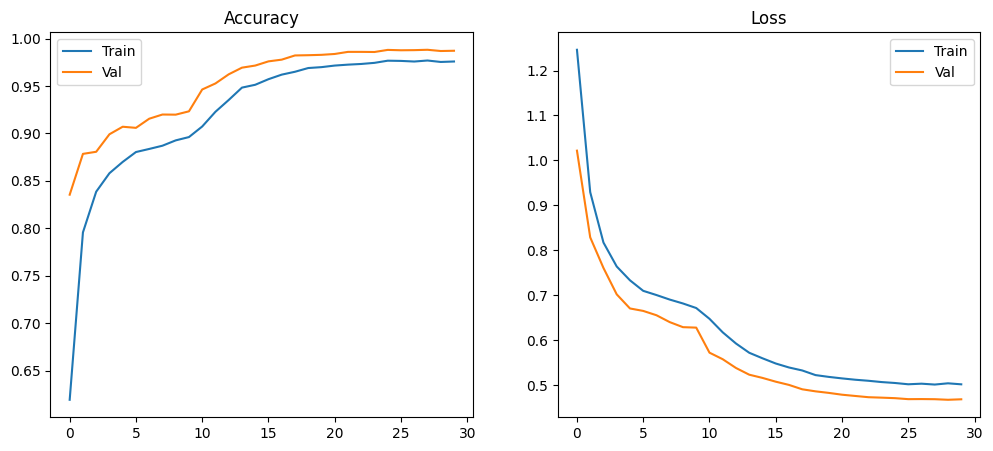

Eval: 100%|██████████| 241/241 [00:20<00:00, 11.92it/s]


                                               precision    recall  f1-score   support

           Citrus_Canker_Diseases_Leaf_Orange     0.9851    0.9869    0.9860      2212
Citrus_Nutrient_Deficiency_Yellow_Leaf_Orange     0.9969    0.9988    0.9979      2599
                          Healthy_Leaf_Orange     0.9739    0.9801    0.9770      1258
                Multiple_Diseases_Leaf_Orange     0.9874    0.9751    0.9812       965
                    Young_Healthy_Leaf_Orange     0.9938    0.9862    0.9900       653

                                     accuracy                         0.9883      7687
                                    macro avg     0.9874    0.9854    0.9864      7687
                                 weighted avg     0.9883    0.9883    0.9883      7687



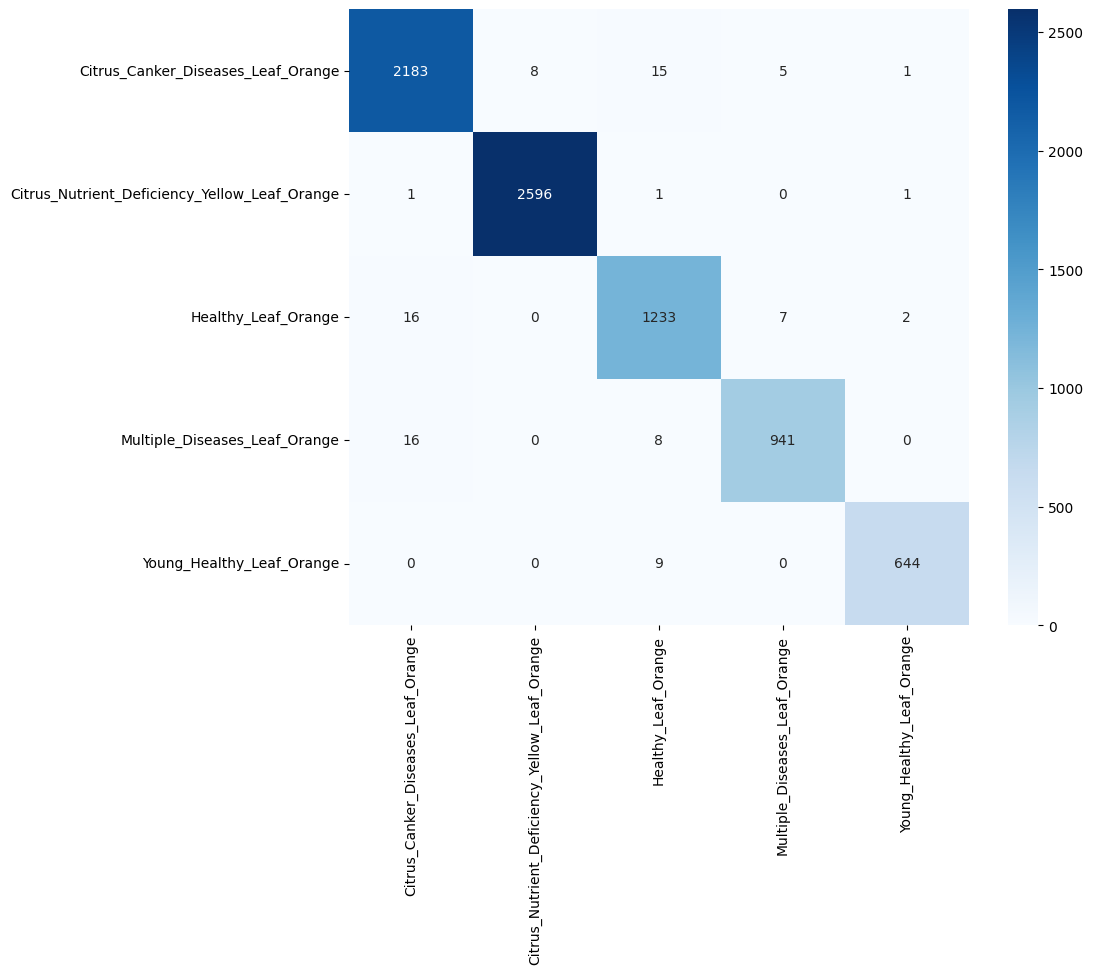

In [5]:
# region 5. Evaluation
if __name__ == '__main__':
    print("\n--- Final Evaluation ---")
    
    acc = hist_fe['t_acc'] + hist_ft['t_acc']
    val_acc = hist_fe['v_acc'] + hist_ft['v_acc']
    loss = hist_fe['t_loss'] + hist_ft['t_loss']
    val_loss = hist_fe['v_loss'] + hist_ft['v_loss']

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.plot(acc, label='Train'); plt.plot(val_acc, label='Val'); plt.title('Accuracy'); plt.legend()
    plt.subplot(1, 2, 2); plt.plot(loss, label='Train'); plt.plot(val_loss, label='Val'); plt.title('Loss'); plt.legend()
    plt.savefig('training_log.png'); plt.show()

    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loaders['val'], desc="Eval"):
            # Update: Channels Last saat evaluasi juga
            inputs = inputs.to(DEVICE, memory_format=torch.channels_last) 
            
            with torch.autocast(device_type=DEVICE.type, dtype=AMP_DTYPE, enabled=True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.savefig('confusion_matrix.png'); plt.show()
# endregion